In [1]:
import numpy as np
from scipy import signal
from sympy import *
import matplotlib.pyplot as plt
from numpy.random import randn
from filterpy.kalman import KalmanFilter
import eom2js

def disp(name: str, symbol: Symbol):
    display(Eq(Dummy(name), symbol, evaluate=False))

def mateq2list(lhs: Matrix, rhs: Matrix):
    L = []
    for i in range(lhs.rows):
        L.append(Eq(lhs[i], rhs[i], evaluate=False))
    return L

In [2]:
m = symbols("m")
T1, T2 = symbols("T1 T2")
a = symbols("alpha")

w, h = symbols("w, h")

# Fuerzas y Torque body frame
F_bf = Matrix([
    (T1-T2)*sin(a),
    (-T1-T2)*cos(a)
])
T = (T1-T2)*(cos(a)*w/2 - sin(a)*h/2)

disp("F", F_bf)
disp("T", T)

Eq(_F, Matrix([
[ (T1 - T2)*sin(alpha)],
[(-T1 - T2)*cos(alpha)]]))

Eq(_T, (T1 - T2)*(-h*sin(alpha)/2 + w*cos(alpha)/2))

In [3]:
theta = symbols("theta", cls=Function)
t = symbols("t")
g = symbols("g")
# Fuerzas en sistema inercial
R = Matrix([
    [cos(theta(t)), -sin(theta(t))],
    [sin(theta(t)), cos(theta(t))]
])

F = R*F_bf + Matrix([0, m*g])

disp("F", F)

Eq(_F, Matrix([
[     -(-T1 - T2)*sin(theta(t))*cos(alpha) + (T1 - T2)*sin(alpha)*cos(theta(t))],
[g*m + (-T1 - T2)*cos(alpha)*cos(theta(t)) + (T1 - T2)*sin(alpha)*sin(theta(t))]]))

In [4]:
x, y = symbols("x, y", cls=Function)

I = 1/12*m*(h**2+w**2)

eom = eom2js.EOM(t, x(t), y(t), theta(t))
eom.param = [g, m, a, w, h]
eom.input = [T1, T2]

# Ecuaciones del movimiento
eqs = mateq2list(diff(Matrix([x(t), y(t)]), t, 2), F/m)
eqs += [Eq(diff(theta(t), t, 2), T/I)]

eom.add_eq(*eqs)
eom.printjs("js/eom.js")

for eq in eom.eqs: display(eq)

Derivative(x(t), t)

Derivative(y(t), t)

Derivative(theta(t), t)

T1*sin(alpha)*cos(theta(t))/m + T1*sin(theta(t))*cos(alpha)/m - T2*sin(alpha)*cos(theta(t))/m + T2*sin(theta(t))*cos(alpha)/m

T1*sin(alpha)*sin(theta(t))/m - T1*cos(alpha)*cos(theta(t))/m - T2*sin(alpha)*sin(theta(t))/m - T2*cos(alpha)*cos(theta(t))/m + g

-6.0*T1*h*sin(alpha)/(h**2*m + m*w**2) + 6.0*T1*w*cos(alpha)/(h**2*m + m*w**2) + 6.0*T2*h*sin(alpha)/(h**2*m + m*w**2) - 6.0*T2*w*cos(alpha)/(h**2*m + m*w**2)

In [5]:
# Linealizar y espacio estado
linear = []
for eq in eqs:
	eq = eq.subs(sin(theta(t)), 0)
	eq = eq.subs(cos(theta(t)), 1)
	eq = eq.subs(g, 0)
	linear += [eq]

linear[0] = Eq(diff(x(t), t, 2), linear[0].rhs + theta(t)*g)

eom_linear = eom2js.EOM(t, x(t), y(t), theta(t))
eom_linear.param = [g, m, a, w, h]
eom_linear.input = [T1, T2]

eom_linear.add_eq(*linear)
for eq in eom_linear.eqs: display(eq)
eom_linear.printjs("js/eom_linear.js")

A = linear_eq_to_matrix(eom_linear.eqs, eom.state())[0]
B = linear_eq_to_matrix(eom_linear.eqs, [T1, T2])[0]
display(A, B)

Derivative(x(t), t)

Derivative(y(t), t)

Derivative(theta(t), t)

T1*sin(alpha)/m - T2*sin(alpha)/m + g*theta(t)

-T1*cos(alpha)/m - T2*cos(alpha)/m

-6.0*T1*h*sin(alpha)/(h**2*m + m*w**2) + 6.0*T1*w*cos(alpha)/(h**2*m + m*w**2) + 6.0*T2*h*sin(alpha)/(h**2*m + m*w**2) - 6.0*T2*w*cos(alpha)/(h**2*m + m*w**2)

Matrix([
[0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0, 1],
[0, 0, g, 0, 0, 0],
[0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0]])

Matrix([
[                                                                       0,                                                                       0],
[                                                                       0,                                                                       0],
[                                                                       0,                                                                       0],
[                                                            sin(alpha)/m,                                                           -sin(alpha)/m],
[                                                           -cos(alpha)/m,                                                           -cos(alpha)/m],
[-6.0*h*sin(alpha)/(h**2*m + m*w**2) + 6.0*w*cos(alpha)/(h**2*m + m*w**2), 6.0*h*sin(alpha)/(h**2*m + m*w**2) - 6.0*w*cos(alpha)/(h**2*m + m*w**2)]])

In [6]:
# Control de espacio estado con posicionamiento de polos
vals = {
	g : 9.81,
	a : np.pi/6,
	m : 24,
	w : 0.2,
	h : 0.3
}

npA = matrix2numpy(A.subs(vals), dtype="float64")
npB = matrix2numpy(B.subs(vals), dtype="float64")
poles = np.array([-0.1, -0.2, -0.3, -0.5, -0.6, -0.7])
K = signal.place_poles(npA, npB, poles)

display(npA, npB, poles, K.gain_matrix)
   
print(eom.printer.doprint((-Matrix(K.gain_matrix)*Matrix(eom.state()))[0]))
print(eom.printer.doprint((-Matrix(K.gain_matrix)*Matrix(eom.state()))[1]))

array([[0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 9.81, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.02083333, -0.02083333],
       [-0.03608439, -0.03608439],
       [ 0.04462516, -0.04462516]])

array([-0.1, -0.2, -0.3, -0.5, -0.6, -0.7])

array([[ 1.02160401e-02, -1.66276616e+00,  9.00668242e+00,
         1.79734374e-01, -1.10851173e+01,  1.73170520e+01],
       [-1.37690088e-02, -1.66277213e+00, -1.02537625e+01,
        -2.22300703e-01, -1.10851332e+01, -1.83494748e+01]])

-9.00668242359435*s.theta - 0.0102160401165573*s.x + 1.6627661565654*s.y - 17.317051994822*s.dtheta - 0.179734374117869*s.dx + 11.0851172572598*s.dy
10.2537624674079*s.theta + 0.0137690087985938*s.x + 1.66277212643942*s.y + 18.3494747507769*s.dtheta + 0.222300703138698*s.dx + 11.08513321895*s.dy


In [7]:
# Integración con euler

# Acción de control en equilibrio, propulsión justa para mantener la nave flotando quieta
control_offset = [vals[g] / (2*np.cos(vals[a])/vals[m])]*2

# Versión numerica de sistema de ecuaciones no lineal
eom_np = lambdify(
	[eom.state()] + [eom.input],
	flatten(Matrix(eom.eqs).subs(vals)), modules="numpy"
)
def fun(t, x, u):
	u = u + control_offset
	return eom_np(x, u)

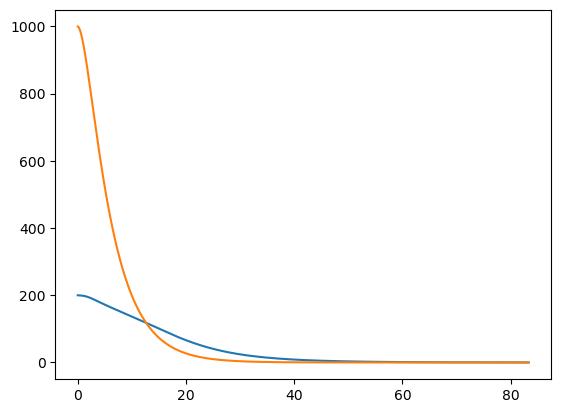

In [16]:
# Simulación sin ruido
# Condiciones iniciales del laboratorio 2
x = np.array([
	200,
	1000,
	0,
	-1,
	-5,
	0
])

# Arrays que almacenan el estado real, tiempo
xs = []
ts = []

# Simulación
timestep = 1/60
for i in range(5000):
	t = i * timestep
	ts.append(t)
	u = np.dot(-K.gain_matrix, x)
	x = x + [xk * timestep for xk in fun(t, x, u)]
	xs.append(x)
xs = np.array(xs)

plt.plot(ts, xs[:,0])
plt.plot(ts, xs[:,1])

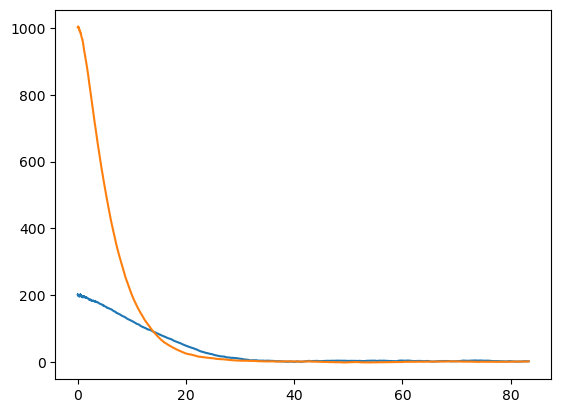

In [22]:
# Simulación con ruido
# Condiciones iniciales del laboratorio 2
x = np.array([
	200,
	1000,
	0,
	-1,
	-5,
	0
])

# Varianza medición
pos_var = 50**2
vel_var = 5**2
giro_var = 0.1**2

# Matrices filtro de Kalman
timestep = 1/60
kf = KalmanFilter(dim_x=6, dim_z=6, dim_u=2)
# Belief
kf.x = np.array([200, 1000, 0, -1, -5, 0])
kf.P = np.diag([100, 100, 1, 100, 100, 1])
# Input
kf.B = npB*timestep
# Proceso
kf.F = npA*timestep + np.diag([1, 1, 1, 1, 1, 1])
kf.Q = 0
# Medición
kf.H = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1]
])
kf.R = np.diag([pos_var, pos_var, giro_var, vel_var, vel_var, giro_var])

# Arrays que almacenan el estado real, tiempo, medición y estado del filtro
xs = []
ts = []
zs = []
kfx = []

# Función para crear mediciones con ruido
def get_measurement(x):
	return [
		x[0] + randn() * np.sqrt(pos_var),
		x[1] + randn() * np.sqrt(pos_var),
		x[2] + randn() * np.sqrt(giro_var),
		x[3] + randn() * np.sqrt(vel_var),
		x[4] + randn() * np.sqrt(vel_var),
		x[5] + randn() * np.sqrt(giro_var),
	]

# Simulación
for i in range(5000):
	# Predicción filtro
	u = np.dot(-K.gain_matrix, kf.x)
	kf.predict(u)
	# Avanzar simulación
	t = i * timestep
	ts.append(t)
	x = x + [xk * timestep for xk in fun(t, x, u)]
	xs.append(x)
	z = get_measurement(x)
	zs.append(z)
	# Introducir medición al filtro
	kf.update(z)
	kfx.append(kf.x)

xs = np.array(xs)
zs = np.array(zs)
kfx = np.array(kfx)

plt.plot(ts, kfx[:,0])
plt.plot(ts, kfx[:,1])